# Classification

This notebook demonstrates how `homonim` can help improve classifier accuracy.  It works with images and ground truth taken from a [vegetation mapping study](https://doi.org/10.1117/1.jrs.12.046022) that sought to identify Spekboom in the Little Karoo, South Africa.  Aerial imagery with 50 cm spatial resolution and 4 spectral bands (red, green, blue and near-infrared) was obtained from the  [NGI](https://ngi.dalrrd.gov.za/index.php/what-we-do/aerial-photography-and-imagery).  Ground truth data consists of ± 160 polygons with labels for 3 classes: 

- Spekboom: a species of succulent shrub.
- Tree: any other tree. 
- Background: other vegetation, bare ground etc.

## Setup

### Install dependencies

`geedim`, `geopandas`, `gdal`, `matplotlib`, `sklearn` and `scipy` are required to run the notebook.  You can uncomment the cell below to install them, if they aren't installed already.

In [ ]:
# import sys
# if 'conda' in sys.prefix:
#     # install into the conda environment the notebook is being run from
#     !conda install --yes --prefix {sys.prefix} -c conda-forge geedim geopandas gdal matplotlib sklearn scipy
# else:
#     # install into the python environment the notebook is being run from
#     !{sys.executable} -m pip install geedim geopandas gdal matplotlib sklearn scipy

In [1]:
# imports used by more than one cell
import logging
import warnings
from pathlib import Path
from matplotlib import pyplot
import numpy as np
import rasterio as rio
from rasterio.plot import show
import pandas as pd
from tqdm.auto import tqdm

import geedim as gd

logging.basicConfig(level=logging.ERROR)

In [2]:
# initialise source and reference paths
from glob import glob
src_root = Path(
    'V:/Data/HomonimEgs/NGI_3321BD-3322AC_2010_LittleKaroo/Source/'
    'GroundTruthSubset'
)
src_mosaic_path = src_root.joinpath(
    'NGI_3321BD-3322AC_2010_LittleKaroo_GroundTruthSubset_Source.vrt'
)
src_paths = [
    Path(src_path) 
    for src_path in glob(str(src_root.joinpath('*_RGBN_CMP.tif')))
]

ref_root = Path(
    'V:/Data/HomonimEgs/NGI_3321BD-3322AC_2010_LittleKaroo/Reference/'
    'GroundTruthSubset'
)
l7_ref_path = ref_root.joinpath('l7_comp_ref.tif')
modis_ref_path = ref_root.joinpath('modis_nbar_ref.tif')

# create a search region that covers the source image mosaic
region = gd.utils.get_bounds(src_mosaic_path)

## Search and download reference images

Use [`geedim`](https://github.com/dugalh/geedim) to search for and download Landsat-7 and MODIS NBAR reference images.

In [3]:
# Note: soure images captured from 2010-01-22 - 2010-02-01
gd.Initialize()

# create and search the Landsat-7 collection
l7_coll = gd.MaskedCollection.from_name('LANDSAT/LE07/C02/T1_L2')
l7_coll = l7_coll.search(
    '2010-01-01', '2010-02-28', region, cloudless_portion=50
)
print('Image property descriptions:\n\n' + l7_coll.schema_table)
print('\nSearch Results:\n\n' + l7_coll.properties_table)

# equivalent geedim command line:
# !geedim search -c l7-c2-l2 -s 2010-01-01 -e 2010-02-28 -cp 50  -r {src_mosaic_path}

Image property descriptions:

ABBREV     NAME                  DESCRIPTION
---------  --------------------  ---------------------------------------
ID         system:id             Earth Engine image id
DATE       system:time_start     Image capture date/time (UTC)
FILL       FILL_PORTION          Portion of valid pixels (%)
CLOUDLESS  CLOUDLESS_PORTION     Portion of cloud/shadow free pixels (%)
GRMSE      GEOMETRIC_RMSE_MODEL  Orthorectification RMSE (m)
SAA        SUN_AZIMUTH           Solar azimuth angle (deg)
SEA        SUN_ELEVATION         Solar elevation angle (deg)

Search Results:

ID                                          DATE              FILL CLOUDLESS GRMSE   SAA   SEA
------------------------------------------- ---------------- ----- --------- ----- ----- -----
LANDSAT/LE07/C02/T1_L2/LE07_173083_20100203 2010-02-03 08:14 92.12     92.10  4.74 73.32 52.10
LANDSAT/LE07/C02/T1_L2/LE07_173083_20100219 2010-02-19 08:14 92.01     92.01  4.58 66.61 49.04


In [4]:
# create a composite of L7 search results to fill in SLE gaps
l7_comp_im = l7_coll.composite(
    gd.CompositeMethod.q_mosaic, date='2010-01-27', 
    resampling=gd.ResamplingMethod.bilinear,
)

# get source mosaic CRS for download parameter
with rio.open(src_mosaic_path, 'r') as ds:
    src_crs = ds.crs.to_wkt()

# download
l7_comp_im.download(
    l7_ref_path, crs=src_crs, scale=30, region=region, scale_offset=True, 
    overwrite=True
)

# equivalent geedim command line:
# !geedim composite  -cm q_mosaic --date 2010-01-27 -i LANDSAT/LE07/C02/T1_L2/LE07_173083_20100203 -i LANDSAT/LE07/C02/T1_L2/LE07_173083_20100219 download --crs {src_crs}  --scale 30 -r {src_mosaic_path}

l7_comp_ref.tif: |                                                     | 0.00/367M (raw) [  0.0%] in 00:00 (et…

In [5]:
# search the MODIS NBAR collection
modis_coll = gd.MaskedCollection.from_name('MODIS/006/MCD43A4')
modis_coll = modis_coll.search(
    '2022-01-27', '2022-01-28', region, 
)
print('Image property descriptions:\n\n' + modis_coll.schema_table)
print('\nSearch Results:\n\n' + modis_coll.properties_table)

# download
modis_image = gd.MaskedImage.from_id(
    'MODIS/006/MCD43A4/2010_01_27', mask=True
)
modis_image.download(
    modis_ref_path, region=region, scale_offset=False, overwrite=True
)

# equivalent geedim command line:
# !geedim search -c modis-nbar -s 2010-01-27 -e 2010-01-28 -r {src_mosaic_path} download -o

Image property descriptions:

ABBREV  NAME               DESCRIPTION
------  -----------------  -----------------------------
ID      system:id          Earth Engine image id
DATE    system:time_start  Image capture date/time (UTC)
FILL    FILL_PORTION       Portion of valid pixels (%)

Search Results:

ID                           DATE             FILL
---------------------------- ---------------- ----
MODIS/006/MCD43A4/2022_01_27 2022-01-27 00:00  100


modis_nbar_ref.tif: |                                                  | 0.00/278k (raw) [  0.0%] in 00:00 (et…

# Correction

Setup correction parameters and paths.

In [6]:
from homonim import Model, ProcCrs, utils
if False:
    # fuse with Landsat-7 and compare with MODIS NBAR
    ref_bands = [3, 2, 1, 4]
    cmp_ref_bands = [1, 4, 3, 2]
    ref_path = l7_ref_path
    cmp_ref_path = modis_ref_path
    model = Model.gain
    kernel_shape = (5, 5)
    corr_root = Path(
        'V:/Data/HomonimEgs/NGI_3321BD-3322AC_2010_LittleKaroo/Corrected/'
        'GroundTruthSubset/L7/'
    )
    ref_sc_off = [.2, 0]
    out_profile = None
else:
    # fuse with MODIS NBAR and compare with Landsat-7
    ref_bands = [1, 4, 3, 2]
    cmp_ref_bands = [3, 2, 1, 4]
    ref_path = modis_ref_path
    cmp_ref_path = l7_ref_path
    model = Model.gain
    kernel_shape = (1, 1)
    corr_root = Path(
        'V:/Data/HomonimEgs/NGI_3321BD-3322AC_2010_LittleKaroo/Corrected/'
        'GroundTruthSubset/Modis/'
    )
    ref_sc_off = [1.7e3, .1]
    out_profile = dict(dtype='uint16', nodata=0)

post_fix = utils.create_out_postfix(
    ProcCrs.ref, model=model, kernel_shape=kernel_shape, driver='GTiff'
)
corr_paths = [
    corr_root.joinpath(src_path.stem + post_fix)
    for src_path in src_paths
]

Fuse aerial images with reference.

In [7]:
from homonim import RasterFuse

for src_path, corr_path in zip(src_paths, corr_paths):
    with RasterFuse(src_path, ref_path, ref_bands=ref_bands) as raster_fuse:
        print(f'{corr_path.name}:')
        raster_fuse.process(
            corr_path, model, kernel_shape, 
            block_config=dict(threads=4, max_block_mem=512), 
            out_profile=out_profile, 
            model_config=dict(mask_partial=False), 
            overwrite=True, 
        )

3321b_3172_12_0415_rgbn_CMP_FUSE_cREF_mGAIN_k1_1.tif:


  0%|                                                                                             |0/4 blocks …

3321b_3172_12_0419_rgbn_CMP_FUSE_cREF_mGAIN_k1_1.tif:


  0%|                                                                                             |0/4 blocks …

3321D_319_04_0121_RGBN_CMP_FUSE_cREF_mGAIN_k1_1.tif:


  0%|                                                                                             |0/8 blocks …

3322c_322_02_0056_rgbn_CMP_FUSE_cREF_mGAIN_k1_1.tif:


  0%|                                                                                             |0/8 blocks …

Create a VRT mosaic of the corrected images to use in the visualisation and evaluation steps.

In [8]:
from osgeo import gdal

# strictly, one should avoid using GDAL and rasterio together, but it doesn't
# create conflicts here
corr_mosaic_path = corr_root.joinpath(
    f'NGI_3321BD-3322AC_2010_LittleKaroo_GroundTruthSubset{post_fix[:-4]}.vrt'
)
ds = gdal.BuildVRT(
    str(corr_mosaic_path.absolute()), [str(cp) for cp in corr_paths]
)
ds.FlushCache()

## Visualise

Display matching extents of the source, reference and corrected images, in the reference CRS.

In [ ]:
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling

# get source crs
with rio.open(src_mosaic_path, 'r') as ds:
    src_crs = ds.crs

fig, axes = pyplot.subplots(
    3, 1, sharex=True, sharey=True, tight_layout=True, figsize=(10, 15), 
    dpi=100
)

# loop over src, ref and corrected images and corrsonding parameters
for im_file, ds_fact, indexes, sc_off, ax, label in zip(
    [src_mosaic_path, ref_path, corr_mosaic_path],
    [16, 1, 16],                           # downsample factor
    [None, ref_bands, None],               # band indices
    [None, ref_sc_off, ref_sc_off],        # colour scale & offset
    axes,
    ['Source', 'Reference', 'Corrected'], 
):
    # read image
    with (rio.open(im_file, 'r')) as ds:
        if ds.crs != src_crs:
            # re-project to source CRS
            ds = WarpedVRT(ds, crs=src_crs, resampling=Resampling.bilinear)
        with ds:
            # read and downsample image
            ds_shape = tuple(np.round(np.array(ds.shape) / ds_fact).astype('int'))
            transform = ds.transform * rio.Affine.scale(ds_fact)

            array = ds.read(indexes=indexes, out_dtype='float32', out_shape=ds_shape)

    # change nodata value to nan
    mask = np.any((array == ds.nodata) | np.isnan(array), axis=(0))
    array[:, mask] = np.nan

    # contrast stretching for display
    if sc_off is not None:
        # scale and offset pixel values
        array = np.clip((array / sc_off[0]) - sc_off[1], 0, 1)
    else:
        # 'normalise' image 2%-98% -> 0-1
        for bi in range(array.shape[0]):
            array[bi] -= np.nanpercentile(array[bi], 1)
            array[bi] /= np.nanpercentile(array[bi], 99)
            array[bi] = np.clip(array[bi], 0, 1)

    # display
    ax = show(array[0:3], transform=transform, interpolation='nearest', ax=ax)
    ax.set_title(label, fontweight='bold')
    ax.axis('off')

Display close-up of ground truth polygons on corrected image background.

In [9]:
import geopandas as gpd

# read ground truth polygons into geo dataframe
groundtruth_path = ref_root.joinpath('LittleKaroo3ClassGroundTruth.gpkg')
class_label_gdf = gpd.GeoDataFrame.from_file(groundtruth_path)

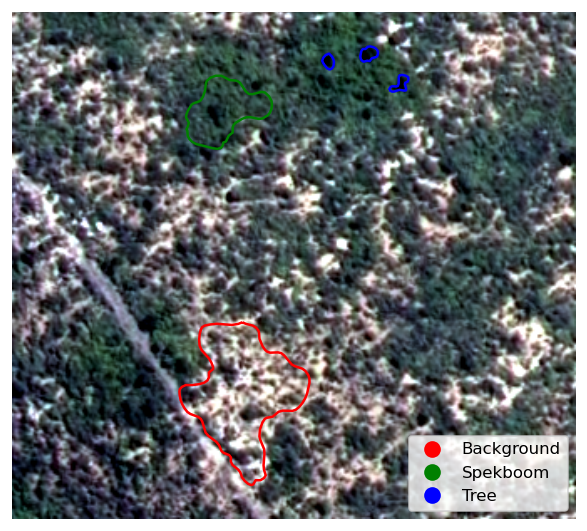

In [58]:
from rasterio import features, windows
from homonim import utils
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ground truth subset of interest
sub_class_label_gdf = class_label_gdf.loc[
    (class_label_gdf.index>=72) & (class_label_gdf.index<77)
]

fig, ax = pyplot.subplots(1, 1, tight_layout=True, figsize=(5, 5), dpi=120)
indexes = (1, 2, 3)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='3%', pad=0.1)

# read, normalise and display corrected mosaic
with rio.open(corr_mosaic_path, 'r') as corr_ds:
    # find window containing ground truth subset
    sub_class_label_gdf = sub_class_label_gdf.to_crs(corr_ds.crs.to_wkt())
    bounds = sub_class_label_gdf.total_bounds
    win = corr_ds.window(*bounds)
    win = utils.expand_window_to_grid(win, (20, 100))
    transform = corr_ds.window_transform(win)
    
    # read image corresponding to window
    array = corr_ds.read(
        indexes=indexes, out_dtype='float32', window=win,
    )

    # change nodata value to nan
    mask = np.any(array == corr_ds.nodata, axis=(0))
    array[:, mask] = np.nan
    
    # 'normalise' image 2%-98% -> 0-1
    for bi in range(len(indexes)):
        array[bi] -= np.nanpercentile(array[bi], 2)
        array[bi] /= np.nanpercentile(array[bi], 98)
        array[bi] = np.clip(array[bi], 0, 1)

    ax = show(array, transform=transform, interpolation='bilinear', ax=ax)

cmap = ListedColormap(['r', 'g', 'b'])
ax = sub_class_label_gdf.plot(
        'Class', kind='geo', ax=ax, linewidth=1.5, facecolor='none', 
        cmap=cmap, legend=True, legend_kwds=dict(loc='lower right')
    )
_ = ax.axis('off')
fig.savefig('../case_studies/classification-groundtruth_polygons.jpg', dpi=120)


## Comparison

Compare corrected images with a second surface reflectance reference.

In [62]:
from homonim import RasterCompare

print(RasterCompare.schema_table())

# loop over the source and corrected image files
for im_path, im_label in zip(
    [src_mosaic_path, corr_mosaic_path],
    ['Source', 'Corrected'],
):
    with RasterCompare(
        im_path, cmp_ref_path, ref_bands=cmp_ref_bands,
    ) as compare:
        # print a table of comparison statistics (the typical way of using 
        # RasterCompare)
        print(f'{im_label}:')
        stats_dict = compare.process()
        print(f'{im_label} comparison:\n\n' + compare.stats_table(stats_dict))

    # equivalent homonim command line:
    # !homonim compare {im_path} {cmp_ref_path}

ABBREV DESCRIPTION
------ -----------------------------------------
r²     Pearson's correlation coefficient squared
RMSE   Root Mean Square Error
rRMSE  Relative RMSE (RMSE/mean(ref))
N      Number of pixels
Source:


  0%|                                                                                           |0/256 blocks …

Source comparison:

 Band    r²    RMSE     rRMSE      N
----- ----- ------- --------- ------
SR_B3 0.557 430.744  4165.340 113164
SR_B2 0.444 680.085  8437.828 113164
SR_B1 0.292 686.888 12458.596 113164
SR_B4 0.387 961.031  5088.672 113164
 Mean 0.420 689.687  7537.609 113164
Corrected:


  0%|                                                                                           |0/256 blocks …

Corrected comparison:

 Band    r²     RMSE     rRMSE      N
----- ----- -------- --------- ------
SR_B3 0.861 1310.340 12671.119 113164
SR_B2 0.827 1010.085 12532.147 113164
SR_B1 0.808  599.652 10876.332 113164
SR_B4 0.829 2395.151 12682.364 113164
 Mean 0.831 1328.807 12190.491 113164


## Classification

Compare classification performance before and after correction with `homonim`.  

### Feature extraction

Extract band pixel values (features) for ground truth polygons

In [59]:
from rasterio import features
from rasterio import windows

def extract_feats(
    ds: rio.DatasetReader, labelled_plot_gdf: gpd.GeoDataFrame
) -> pd.DataFrame:
    """ Extract pixel features from image for given plots. """
    px_feats_dict = dict(plot_id=[], label=[])

    # loop over ground truth plots
    for plot_id, plot in tqdm(
        labelled_plot_gdf.to_crs(ds.crs).iterrows(), 
        total=labelled_plot_gdf.shape[0], desc=im_path.name, 
        dynamic_ncols=True,
    ):
        if plot.Class is None:
            continue

        # find a rasterio window that contains the plot polygon
        bounds = features.bounds(plot.geometry)
        win = windows.from_bounds(*bounds, transform=ds.transform)
        win = utils.expand_window_to_grid(win)

        # read the image array corresponding to the plot window
        array = ds.read(out_dtype='float64', window=win)

        # find a mask for pixels contained inside the plot polygon
        win_transform = ds.window_transform(win)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')     # ignore shapely deprecation warning            
            mask = ~features.geometry_mask(
                plot.geometry, (win.height, win.width), transform=win_transform
            )

        def app_listval(d: dict, k: str, val: list):
            """ Append a list to a dictionary value. """
            if k in d:
                d[k] += val
            else:
                d[k] = val
            return d

        # extract band values for pixels inside polygon
        for bi, fname in zip([0, 1, 2, 3], ['R', 'G', 'B', 'NIR']):
            feat = array[bi]
            featv = list(feat[mask])
            px_feats_dict = app_listval(px_feats_dict, fname, featv)

        # copy plot id and class label for these pixels
        px_feats_dict['plot_id'] += [plot_id] * len(featv)
        px_feats_dict['label'] += [plot.Class] * len(featv)
    
    df = pd.DataFrame(px_feats_dict)
    return df

# loop over source and corrected image mosaics
feats = []
for im_path in [src_mosaic_path, corr_mosaic_path]:    
    # extract and store features
    with rio.open(im_path, 'r') as ds:
        feats_gdf = extract_feats(ds, class_label_gdf)
    feats_gdf['label_i'] = pd.Categorical(feats_gdf['label']).codes
    feats.append(feats_gdf)
feats_dict = dict(zip(['Source', 'Corrected'], feats))

NGI_3321BD-3322AC_2010_LittleKaroo_GroundTruthSubset_Source.vrt:   0%|                         | 0/161 [00:00<…

NGI_3321BD-3322AC_2010_LittleKaroo_GroundTruthSubset_FUSE_cREF_mGAIN_k1_1.vrt:   0%|           | 0/161 [00:00<…

### Feature visualisation

Visualise scatter of source and corrected features.

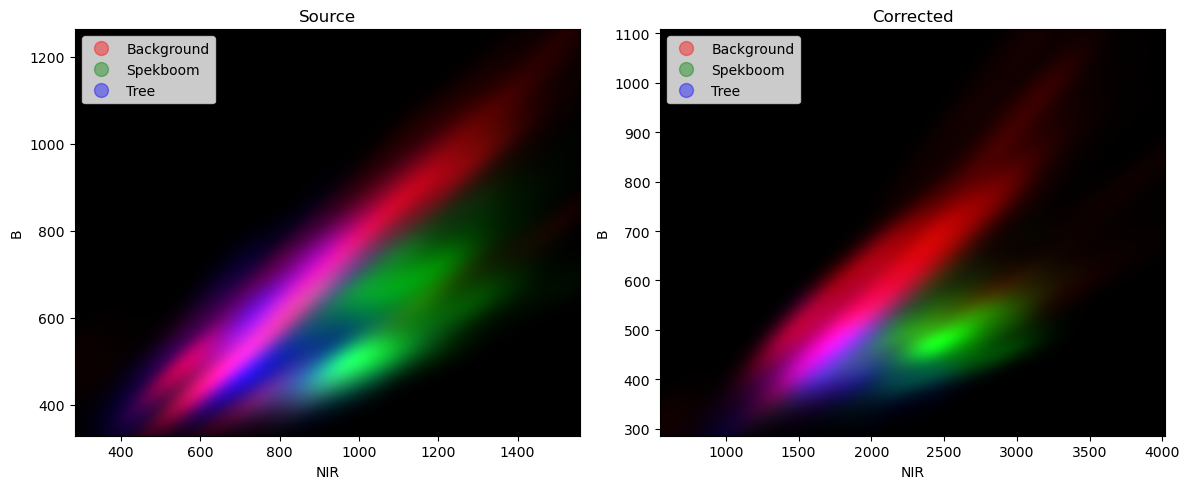

In [60]:
from scipy import stats
from matplotlib import cm

def class_kde(
    df: pd.DataFrame, x=None, y=None, label_col='label', ax=None
):
    """ Feature KDE plot, with class colour coding. """
    colours = dict(zip(
        pd.Categorical(feats_gdf[label_col]).categories, 
        ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'o']
    ))
    
    def get_ptile_range(v, n=200):
        """ Return a percentile linear range of the given vector. """
        return np.linspace(
            np.percentile(v, .25), np.percentile(v, 98), n
        )
    
    # create KDE grid
    xrange = get_ptile_range(df[x])
    yrange = get_ptile_range(df[y])
    xx, yy = np.meshgrid(xrange, yrange)  
    pos = np.vstack([xx.ravel(), yy.ravel()])
    kdes = []
    
    # create per-class KDEs
    for label, group in df.groupby(label_col):
        val = np.vstack([group[x], group[y]])
        kernel = stats.gaussian_kde(val)
        kde = np.reshape(kernel(pos).T, xx.shape)
        kde /= kde.max()
        kdes.append(kde)
        # cset = ax.contour(
        #     xx, yy, kde, colors=colours[label], alpha=0.4, 
        # )
        # dummy plot for the legend
        ax.plot(xx[0], yy[0], f'{colours[label]}o', ms=10, alpha=0, label=label)
    
    # display RGB image of KDEs
    im = np.dstack(kdes)
    ax.imshow(
        im, extent=[xrange[0], xrange[-1], yrange[0], yrange[-1]], 
        interpolation='bilinear', origin='lower'
    )
    ax.axis('auto')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    for lh in ax.legend(loc='upper left').legendHandles: 
        lh.set_alpha(.4)


fig, axes = pyplot.subplots(
    1, 2, tight_layout=True, figsize=(12, 5), dpi=100, 
)

for feats_df, ax, label in zip(
    feats_dict.values(), axes, feats_dict.keys(),
):
    class_kde(feats_df.iloc[::10], 'NIR', 'B', ax=ax)
    ax.set_title(label)

fig.savefig('../case_studies/classification-sprectral_kde.jpg', dpi=150)

### Classification accuracy

Evaluate the accuracy of a naive Bayes classifier on the source and corrected features.

In [61]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

def train_test(
    X: np.ndarray, y: np.ndarray, groups: np.ndarray = None, n_splits=10,
    clf = GaussianNB()
) -> np.ndarray:
    """ 
    Train and test a classifier on the given features and labels using 
    cross-validation. 
    """
    if groups is not None:
        tr_ts_indices = StratifiedGroupKFold(n_splits=n_splits).split(
            X, y, groups
        )
    else:
        tr_ts_indices = StratifiedKFold(n_splits=n_splits).split(X, y)
    
    ypred = np.zeros_like(y)
    for train, test in tqdm(
        tr_ts_indices, dynamic_ncols=True, total=n_splits
    ):
        Xtr = X[train, :]
        ytr = y[train]
        Xts = X[test, :]
        yts = y[test]
        clf.fit(Xtr, ytr)
        ypred[test] = clf.predict(Xts)
    return ypred

# loop over source and corrected features
label_col = 'label'
for df_label, df in feats_dict.items():
        # raw spectral band feature matrix
    X = df[['R', 'G', 'B', 'NIR']].to_numpy()
    # convert string class labels to int codes
    y = pd.Categorical(df[label_col]).codes  
    
    class_labels = pd.Categorical(df[label_col]).categories
    # equal prior weighting for classifier
    priors = np.ones(len(class_labels)) / len(class_labels)
    if False:
        # pipeline of scaler, PCA & naive baye
        scaler = StandardScaler()
        pca = PCA(n_components=2)
        nb = GaussianNB(priors=priors)
        clf = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("clf", nb)])
    else:
        clf = GaussianNB(priors=priors)

    ypred = train_test(
        X, y, groups=df.plot_id.to_numpy(), clf=clf, n_splits=10
    )
    
    # find and print accuracy scores
    cm = confusion_matrix(y, ypred)
    cm_norm = cm / cm.sum(axis=1).reshape(-1, 1)
    cm_df = pd.DataFrame(data=cm, columns=class_labels, index=class_labels)
    cm_norm_df = pd.DataFrame(
        data=cm_norm, columns=class_labels, index=class_labels
    )

    print(f'{df_label}:')
    print(f'Confusion matrix:')
    print(tabulate(cm_df, headers=cm_df.columns, tablefmt='rst', floatfmt='.2f'))
    print(f'\nConfusion matrix (normalised):')
    print(tabulate(cm_norm_df, headers=cm_norm_df.columns, tablefmt='rst', floatfmt='.2f'))
    print(f'\nAccuracy: {100*np.sum(np.diag(cm))/np.sum(cm[:]):.2f}')
    print(f'Accuracy (normalised): {100*np.mean(np.diag(cm_norm)):.2f}')

  0%|                                                                                           | 0/10 [00:00<…

Source:
Confusion matrix:
==========  ==========  ========  ========
..          Background  Spekboom      Tree
==========  ==========  ========  ========
Background    91848.00  28567.00  92050.00
Spekboom       3934.00  26769.00  12484.00
Tree            670.00   2330.00   7007.00
==========  ==========  ========  ========

Confusion matrix (normalised):
==========  ==========  ========  ====
..          Background  Spekboom  Tree
==========  ==========  ========  ====
Background        0.43      0.13  0.43
Spekboom          0.09      0.62  0.29
Tree              0.07      0.23  0.70
==========  ==========  ========  ====

Accuracy: 47.29
Accuracy (normalised): 58.41


  0%|                                                                                           | 0/10 [00:00<…

Corrected:
Confusion matrix:
==========  ==========  ========  ========
..          Background  Spekboom      Tree
==========  ==========  ========  ========
Background   118607.00  35112.00  58746.00
Spekboom       2973.00  31256.00   8958.00
Tree            429.00   2151.00   7427.00
==========  ==========  ========  ========

Confusion matrix (normalised):
==========  ==========  ========  ====
..          Background  Spekboom  Tree
==========  ==========  ========  ====
Background        0.56      0.17  0.28
Spekboom          0.07      0.72  0.21
Tree              0.04      0.21  0.74
==========  ==========  ========  ====

Accuracy: 59.21
Accuracy (normalised): 67.47
